# Part 5: Machine Learning Enhancement (Leakage-Free)

This notebook improves the baseline trading strategy using a machine learning
filter while explicitly avoiding data leakage.

Only market-state and informational features are used.
Signal-defining features (EMA crossover logic) are excluded.


## Task 5.1: Problem Definition

Objective:
Predict whether a baseline trade will be profitable using only
market context and informational features.

Target:
- 1 → Profitable trade
- 0 → Non-profitable trade

Leakage Control:
- EMA indicators and position signals are excluded
- No forward-looking or signal-derived features are used


In [79]:
import pandas as pd
import numpy as np

df = pd.read_csv("baseline_strategy_ml_ready.csv")
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,close_spot,regime,ema_5,ema_15,position,spot_return,strategy_return,equity,ml_target,ema_spread,ret_lag_1,ret_lag_2,ret_lag_3
0,2025-01-20,23344.75,-1,23262.096914,23216.209680,0.0,0.006100,0.000000,1.000000,0,45.887233,-0.004659,0.004248,0.001603
1,2025-01-21,23024.65,-1,23182.947942,23192.264720,-1.0,-0.013712,-0.000000,1.000000,0,-9.316778,0.006100,-0.004659,0.004248
2,2025-01-22,23155.35,-1,23173.748628,23187.650380,-1.0,0.005677,-0.005677,0.994323,0,-13.901752,-0.013712,0.006100,-0.004659
3,2025-01-23,23205.35,-1,23184.282419,23189.862833,-1.0,0.002159,-0.002159,0.992176,0,-5.580414,0.005677,-0.013712,0.006100
4,2025-01-24,23092.20,-1,23153.588279,23177.654979,-1.0,-0.004876,0.004876,0.997014,1,-24.066699,0.002159,0.005677,-0.013712


### Feature Selection (Leakage-Free)

Removed:
- EMA indicators
- EMA spread
- Position / signal columns

Kept:
- Regime labels
- Lagged returns
- Futures basis
- Option Greeks & IV features


In [80]:
FEATURES = [
    'regime',
    'ret_lag_1',
    'ret_lag_2',
    'ret_lag_3'
]

TARGET = 'ml_target'

X = df[FEATURES]
y = df[TARGET]

Train/Test Split:
- First 70% → Training
- Last 30% → Testing
(Time-ordered, no shuffling)


In [81]:
split = int(0.7 * len(df))

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# MODEL TRAINING

### Model: XGBoost Classifier

- Handles non-linear relationships
- Robust to noisy financial features
- Suitable for tabular time-series data

In [82]:
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

XGB_MODEL_PATH = "xgboost_trade_classifier.json"

if os.path.exists(XGB_MODEL_PATH):
    print("Loading existing XGBoost model...")

    xgb = XGBClassifier()
    xgb.load_model(XGB_MODEL_PATH)

else:
    print("Training new XGBoost model...")

    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    )

    xgb.fit(X_train, y_train)

    xgb.save_model(XGB_MODEL_PATH)
    print(f"XGBoost model saved to {XGB_MODEL_PATH}")

Loading existing XGBoost model...


In [83]:
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

XGBoost Accuracy: 0.4864864864864865
              precision    recall  f1-score   support

           0       0.47      0.50      0.49        36
           1       0.50      0.47      0.49        38

    accuracy                           0.49        74
   macro avg       0.49      0.49      0.49        74
weighted avg       0.49      0.49      0.49        74



In [84]:
xgb.save_model("xgboost_trade_classifier.json")

## Model B: LSTM Classifier

The LSTM model is trained to predict trade profitability using
a sequence of past market-state features.

Input:
- Sequence length: Last 10 candles
- Features: Regime + lagged returns

Architecture:
LSTM → Dropout → Dense → Output


In [85]:
from sklearn.preprocessing import StandardScaler
import numpy as np

SEQ_LEN = 10

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)

split_seq = int(0.7 * len(X_seq))

X_train_seq, X_test_seq = X_seq[:split_seq], X_seq[split_seq:]
y_train_seq, y_test_seq = y_seq[:split_seq], y_seq[split_seq:]

In [86]:
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense

LSTM_MODEL_PATH = "lstm_trade_classifier.keras"

if os.path.exists(LSTM_MODEL_PATH):
    print("Loading existing LSTM model...")
    lstm_model = load_model(LSTM_MODEL_PATH)

else:
    print("Training new LSTM model...")

    lstm_model = Sequential([
        LSTM(64, input_shape=(SEQ_LEN, X.shape[1])),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])

    lstm_model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    lstm_model.fit(
        X_train_seq,
        y_train_seq,
        epochs=15,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    lstm_model.save(LSTM_MODEL_PATH)
    print(f"LSTM model saved to {LSTM_MODEL_PATH}")

Loading existing LSTM model...


In [87]:
lstm_probs = lstm_model.predict(X_test_seq).flatten()
lstm_preds = (lstm_probs > 0.5).astype(int)

from sklearn.metrics import accuracy_score, classification_report

print("LSTM Accuracy:", accuracy_score(y_test_seq, lstm_preds))
print(classification_report(y_test_seq, lstm_preds))

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
LSTM Accuracy: 0.43661971830985913
              precision    recall  f1-score   support

           0       0.45      0.71      0.56        35
           1       0.38      0.17      0.23        36

    accuracy                           0.44        71
   macro avg       0.41      0.44      0.39        71
weighted avg       0.41      0.44      0.39        71



In [88]:
lstm_model.save("lstm_trade_classifier.keras")

## ML-Enhanced Backtest

Trades are taken only when:
- Baseline strategy gives a signal
- ML model predicts profitability (confidence > 0.5)

We compare:
- Baseline strategy
- XGBoost-filtered strategy
- LSTM-filtered strategy


In [89]:
split = int(0.7 * len(df))

df_train = df.iloc[:split].copy()
df_test  = df.iloc[split:].copy()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [90]:
df_test['baseline_equity'] = (1 + df_test['strategy_return']).cumprod()

In [91]:
df_test['xgb_conf'] = xgb_probs
df_test['xgb_trade'] = (df_test['xgb_conf'] > 0.5).astype(int)

df_test['xgb_strategy_return'] = (
    df_test['strategy_return'] * df_test['xgb_trade']
)

df_test['xgb_equity'] = (1 + df_test['xgb_strategy_return']).cumprod()

In [92]:
SEQ_LEN = 10

df_test_lstm = df_test.iloc[SEQ_LEN:].copy()
df_test_lstm.reset_index(drop=True, inplace=True)

In [93]:
lstm_probs_aligned = lstm_probs[-len(df_test_lstm):]

In [94]:
df_test_lstm['lstm_conf'] = lstm_probs_aligned
df_test_lstm['lstm_trade'] = (df_test_lstm['lstm_conf'] > 0.5).astype(int)

df_test_lstm['lstm_strategy_return'] = (
    df_test_lstm['strategy_return'] * df_test_lstm['lstm_trade']
)

df_test_lstm['lstm_equity'] = (1 + df_test_lstm['lstm_strategy_return']).cumprod()

<Axes: title={'center': 'Baseline vs XGBoost vs LSTM – ML Enhanced Backtest'}>

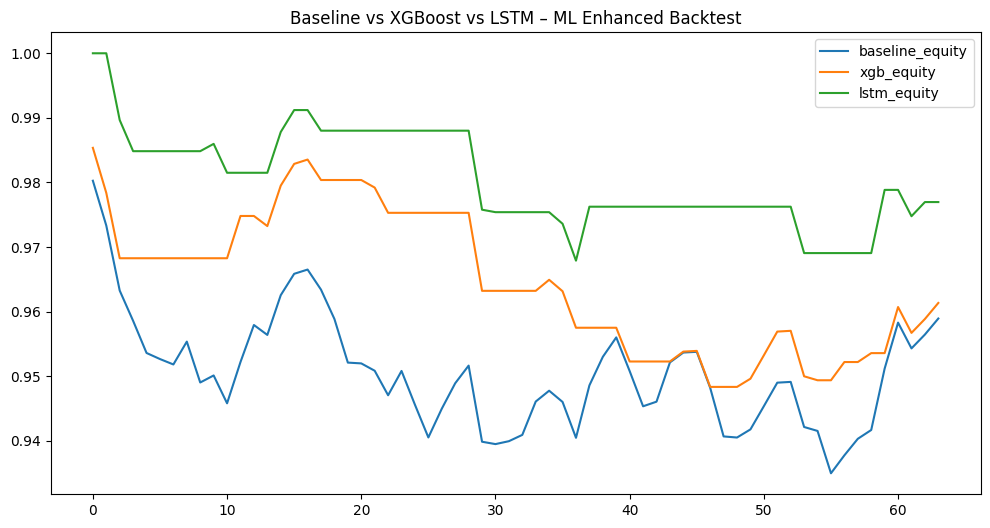

In [95]:
comparison.plot(
    figsize=(12, 6),
    title='Baseline vs XGBoost vs LSTM – ML Enhanced Backtest'
)

In [96]:
comparison = pd.DataFrame({
    'baseline_equity': df_test['baseline_equity'].iloc[SEQ_LEN:].values,
    'xgb_equity': df_test['xgb_equity'].iloc[SEQ_LEN:].values,
    'lstm_equity': df_test_lstm['lstm_equity'].values
})

comparison.tail()

,baseline_equity,xgb_equity,lstm_equity
59,0.951195,0.953588,0.978856
60,0.958310,0.960721,0.978856
61,0.954319,0.956720,0.974779
62,0.956464,0.958870,0.976970
63,0.958943,0.961355,0.976970


In [97]:
# Columns we WANT to save
cols_to_save = [
    'date',
    'regime',
    'strategy_return',
    'baseline_equity',
    'xgb_conf', 'xgb_trade', 'xgb_strategy_return', 'xgb_equity',
    'lstm_conf', 'lstm_trade', 'lstm_strategy_return', 'lstm_equity',
    'avg_iv', 'iv_spread',
    'pcr_oi', 'pcr_vol',
    'delta_neutral_ratio', 'gamma_exposure',
    'ema_spread',
    'spot_return'
]

# Keep only columns that actually exist
cols_to_save = [c for c in cols_to_save if c in final_df.columns]

print("Saving columns:")
print(cols_to_save)

Saving columns:
['date', 'regime', 'strategy_return', 'baseline_equity', 'xgb_conf', 'xgb_trade', 'xgb_strategy_return', 'xgb_equity', 'lstm_conf', 'lstm_trade', 'lstm_strategy_return', 'lstm_equity', 'ema_spread', 'spot_return']


In [100]:
final_df[cols_to_save].to_csv(
    "nifty_ml_backtest_daily.csv",
    index=False
)